In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import cv2
import imutils

import numpy as np
import matplotlib.pyplot as plt

import time

In [5]:
def crop_brain_contour(image):
    """crops the image by finding its extream top, bottom, left, right"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    return new_image

In [4]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img)


In [3]:
from os import listdir


def load_data(dir_list: list, image_size: tuple):
    """Read the image, resize it, and normalize them"""
    X = []
    y = []
    image_width, image_height = image_size

    for dir in dir_list:
        for filename in listdir(dir):
            # load the image
            image = cv2.imread(dir + "//" + filename)
            # crop the image
            image = crop_brain_contour(image)
            # resize
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize the values
            image = image / 255
            X.append(image)
            if dir[-3:] == "yes":
                y.append([1])
            else:
                y.append([0])
    
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    return X, y

In [6]:

from keras.preprocessing.image import ImageDataGenerator
from os import listdir

def augment_data(file_dir, n_generated_samples, save_to_dir):
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '//' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [8]:
augmented_data_path = 'augmented_data/'

augment_data(file_dir="yes", n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir="no", n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [6]:
augmented_path = 'augmented_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
def plot_sample_images(X, y, n=50):
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

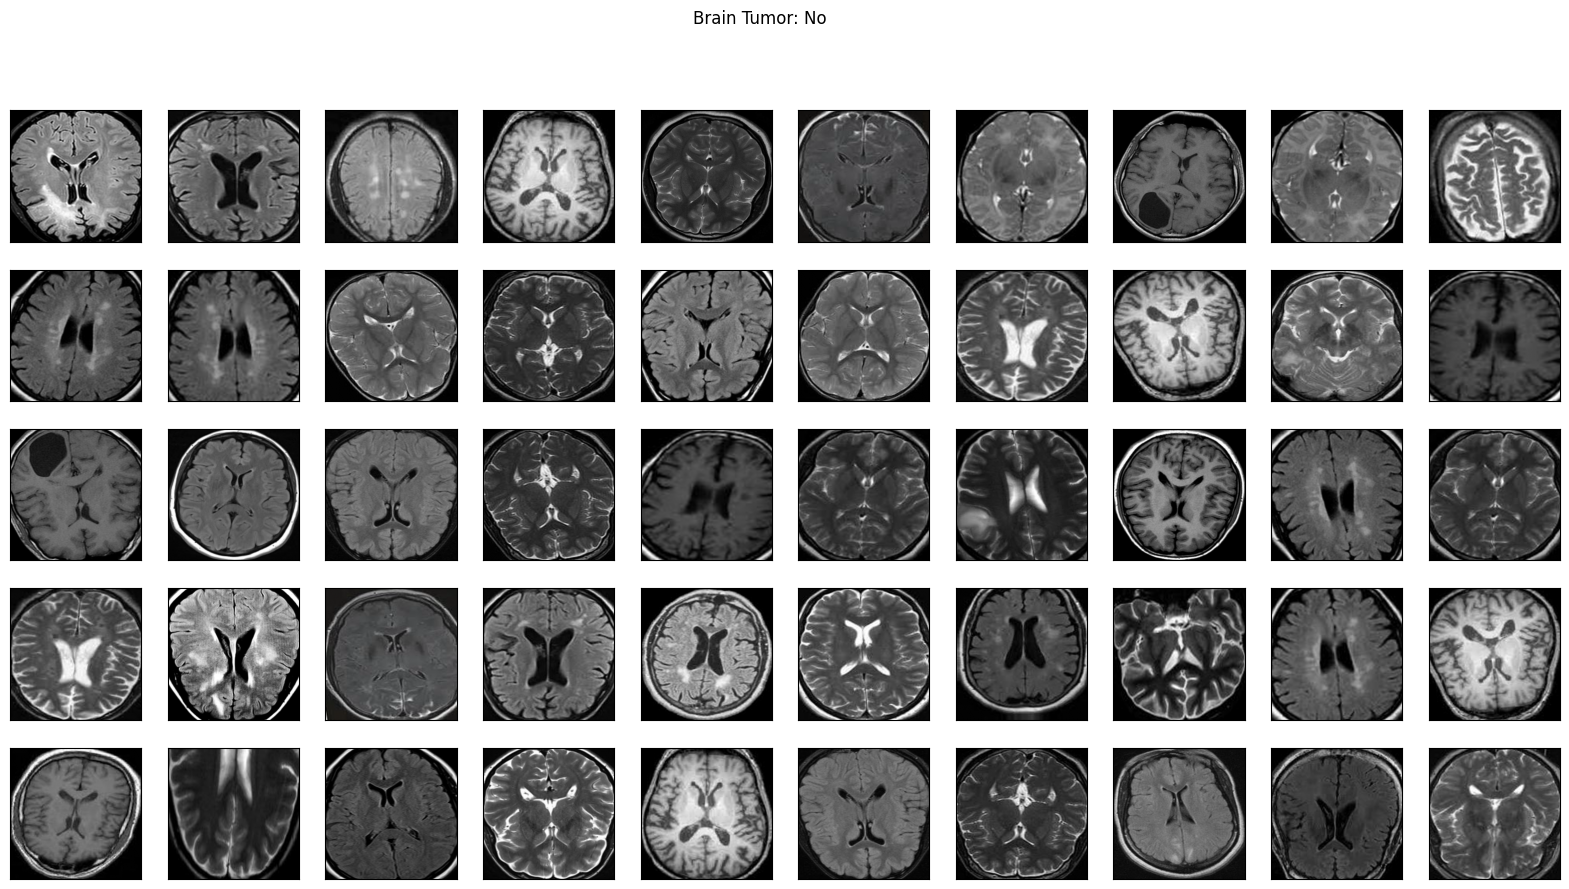

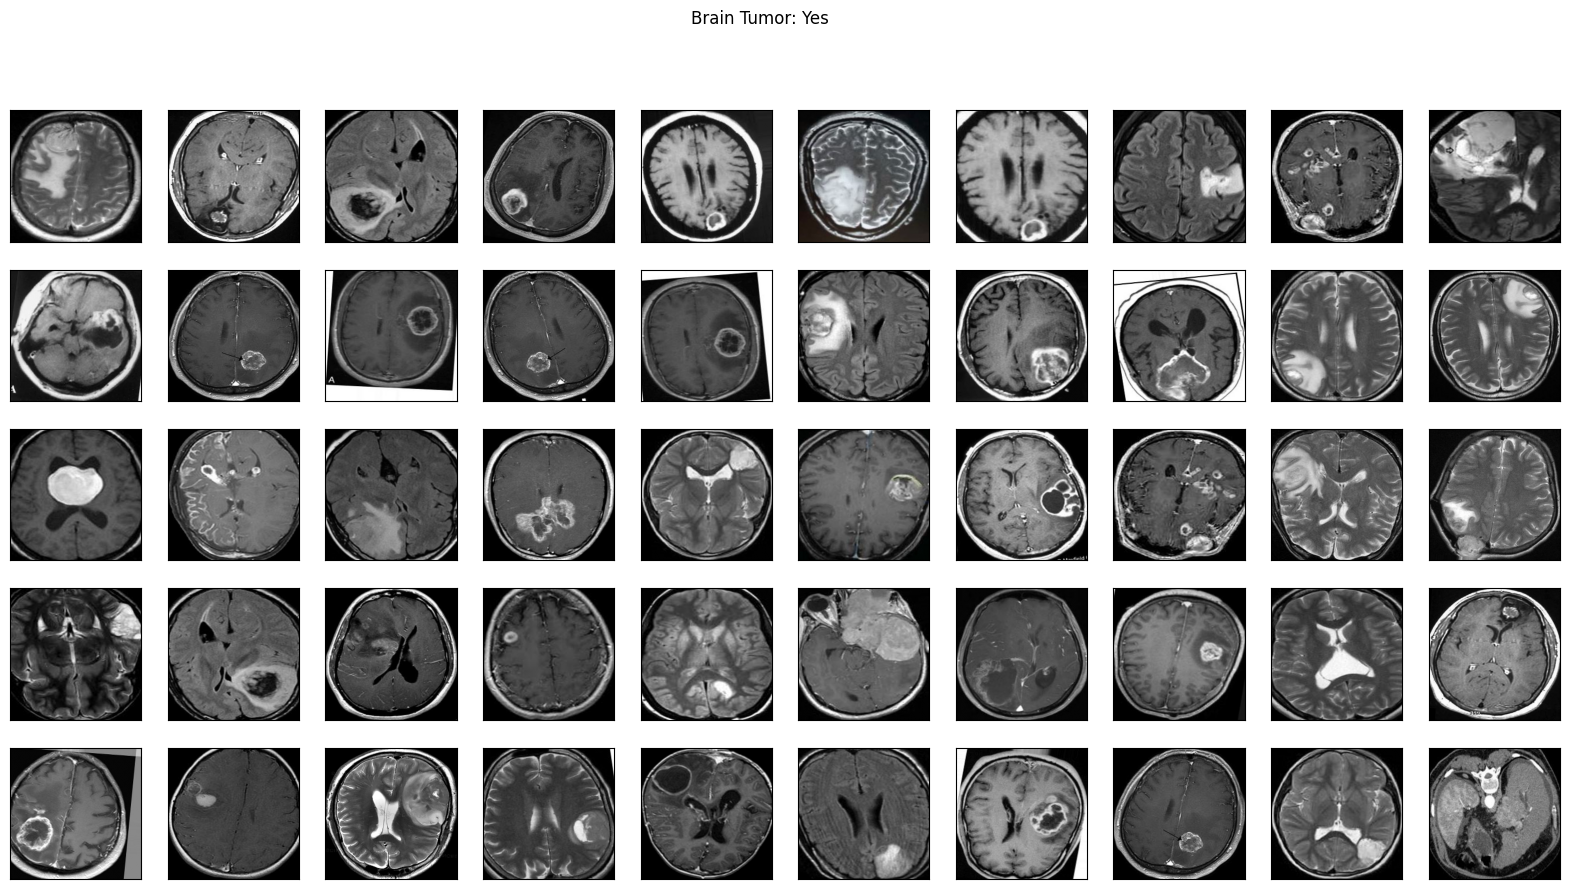

In [ ]:
plot_sample_images(X, y)

In [7]:
def split_data(X, y, test_size=0.2):  
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [9]:
input_shape = (240, 240, 3)

# def build_model(input_shape):
model = Sequential()
# add the Zeropadding layer
model.add(ZeroPadding2D((2, 2), input_shape=input_shape))

# convolution layer
model.add(Conv2D(32, kernel_size=(7, 7), strides=(1, 1), activation="relu"))
model.add(BatchNormalization(axis=3))

# maxpooling layers
model.add(MaxPooling2D(4, 4))
model.add(MaxPooling2D(4, 4))

# flatten the layers
model.add(Flatten())
# model.add(Dense(10, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

# model

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 238, 238, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                    

In [11]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
46/46 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.6484

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
